In [132]:
# !pip install -q prophet==1.2.1
!pip install -q prophet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [133]:
# Path data
data_path = "/content/drive/MyDrive/ColabNotebooks/VisDatLanjut/Final Project/Data Cuaca BMKG Kota Bandung 2024-25.xlsx"
df_raw = pd.read_excel(data_path)

# Rename kolom agar konsisten & mudah dipakai
df_raw = df_raw.rename(columns={
    "TANGGAL": "Date",
    "TN": "Temp_Min",
    "TX": "Temp_Max",
    "TAVG": "Temp_Avg",
    "RH_AVG": "Humidity",
    "RR": "Rain",
    "SS": "Sunshine",
    "FF_X": "Wind_Max",
    "DDD_X": "Wind_Dir_Max",
    "FF_AVG": "Wind_Avg",
    "DDD_CAR": "Wind_Dir_Dom"
})

df_raw["Date"] = pd.to_datetime(df_raw["Date"], format="%d-%m-%Y", errors="coerce")

print(df_raw.head())

        Date  Temp_Min  Temp_Max  Temp_Avg  Humidity  Rain  Sunshine  \
0 2024-01-01      20.8      30.0      25.3      81.0  37.1       4.1   
1 2024-01-02      22.4      30.4      25.6      82.0   3.8       2.7   
2 2024-01-03      22.4      28.8      24.9      83.0   6.4       1.1   
3 2024-01-04      22.0      26.8      22.5      91.0   1.6       1.4   
4 2024-01-05      20.2      29.6      23.9      82.0  32.5       0.0   

   Wind_Max  Wind_Dir_Max  Wind_Avg Wind_Dir_Dom  
0         3            24         0           C   
1         1            90         0           C   
2         3           280         1           C   
3         2           120         0           C   
4         5           210         0           C   


In [134]:
# Group per hari (jaga-jaga jika ada duplikasi)
df = df_raw.groupby("Date", as_index=False).mean(numeric_only=True)
df.drop(columns=["Wind_Dir_Max"], inplace=True)

# Set index & frequency harian
df = df.set_index("Date").asfreq("D")
df.index.freq = "D"

In [135]:
BMKG_MISSING_CODE = 8888

for col in ["Temp_Min", "Temp_Max", "Temp_Avg", "Humidity", "Rain", "Sunshine"]:
    df.loc[df[col] == BMKG_MISSING_CODE, col] = np.nan

In [136]:
df.describe()

,Temp_Min,Temp_Max,Temp_Avg,Humidity,Rain,Sunshine,Wind_Max,Wind_Avg
count,729.000000,730.000000,730.000000,730.000000,642.000000,730.000000,731.000000,731.000000
mean,20.660082,30.436164,24.438767,78.157534,7.299221,4.810274,3.054720,0.467852
std,1.063304,1.553060,0.973470,7.104055,12.235433,2.301259,1.252839,0.541427
min,16.200000,25.400000,21.300000,49.000000,0.000000,0.000000,0.000000,0.000000
25%,20.200000,29.600000,23.800000,74.000000,0.000000,3.225000,2.000000,0.000000
50%,20.800000,30.500000,24.400000,79.000000,1.500000,5.000000,3.000000,0.000000
75%,21.400000,31.400000,25.100000,83.000000,9.000000,6.700000,4.000000,1.000000
max,23.000000,35.400000,28.200000,96.000000,104.400000,8.900000,12.000000,2.000000


In [137]:
def prophet_impute_safe(series):
    """
    Imputasi hanya untuk nilai NaN menggunakan Prophet (AMAN & INDEX-SAFE).
    Data asli TIDAK ditimpa.
    """
    # Copy supaya tidak mengubah data asli
    s = series.copy()

    # Kalau semua NaN → skip
    if s.isna().all():
        return s

    # Siapkan data Prophet
    temp = pd.DataFrame({
        "ds": s.index,
        "y": s.values
    })

    # Fit hanya pada data non-NaN
    model = Prophet(
        daily_seasonality=True,
        yearly_seasonality=True
    )
    model.fit(temp.dropna())

    # Predict full range
    forecast = model.predict(temp)

    # Ambil yhat sebagai array
    yhat = forecast["yhat"].values

    # Isi hanya posisi NaN
    s.iloc[s.isna().values] = yhat[s.isna().values]

    return s

In [138]:
# Variabel kontinu → Prophet
for col in ["Temp_Min", "Temp_Max", "Temp_Avg", "Humidity", "Rain", "Sunshine"]:
    df[col] = prophet_impute_safe(df[col])
    df[col] = df[col].round(1)

In [139]:
df.describe()

,Temp_Min,Temp_Max,Temp_Avg,Humidity,Rain,Sunshine,Wind_Max,Wind_Avg
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,20.659234,30.435705,24.438440,78.151710,7.220520,4.811081,3.054720,0.467852
std,1.062515,1.552046,0.972843,7.100934,11.556138,2.299786,1.252839,0.541427
min,16.200000,25.400000,21.300000,49.000000,-0.400000,0.000000,0.000000,0.000000
25%,20.150000,29.600000,23.800000,74.000000,0.000000,3.250000,2.000000,0.000000
50%,20.800000,30.500000,24.400000,79.000000,2.500000,5.000000,3.000000,0.000000
75%,21.400000,31.400000,25.100000,83.000000,9.250000,6.700000,4.000000,1.000000
max,23.000000,35.400000,28.200000,96.000000,104.400000,8.900000,12.000000,2.000000


In [140]:
df

,Temp_Min,Temp_Max,Temp_Avg,Humidity,Rain,Sunshine,Wind_Max,Wind_Avg
Date,,,,,,,,
2024-01-01,20.8,30.0,25.3,81.0,37.1,4.1,3.0,0.0
2024-01-02,22.4,30.4,25.6,82.0,3.8,2.7,1.0,0.0
2024-01-03,22.4,28.8,24.9,83.0,6.4,1.1,3.0,1.0
2024-01-04,22.0,26.8,22.5,91.0,1.6,1.4,2.0,0.0
2024-01-05,20.2,29.6,23.9,82.0,32.5,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...
2025-12-27,22.2,29.8,25.1,71.0,1.5,4.6,3.0,1.0
2025-12-28,21.6,32.4,24.2,78.0,0.0,4.7,5.0,0.0
2025-12-29,21.0,31.4,24.2,79.0,10.6,5.1,2.0,0.0


In [141]:
# def prophet_backcast(series, years_back=2):
#     """
#     Generate synthetic historical data using Prophet backcasting
#     via time-reversal (methodologically correct).
#     """
#     s = series.copy().dropna()

#     if s.empty:
#         return s

#     # Reverse time
#     s_rev = s[::-1]

#     df_rev = pd.DataFrame({
#         "ds": pd.date_range(
#             start="2000-01-01",
#             periods=len(s_rev),
#             freq="D"
#         ),
#         "y": s_rev.values
#     })

#     model = Prophet(
#         daily_seasonality=True,
#         yearly_seasonality=True
#     )
#     model.fit(df_rev)

#     days_back = 365 * years_back
#     future = model.make_future_dataframe(
#         periods=days_back,
#         freq="D"
#     )

#     forecast = model.predict(future)

#     # Ambil bagian "forecast"
#     backcast = forecast.iloc[-days_back:][["ds", "yhat"]]

#     # Buat index tanggal ke masa lalu
#     last_date = s.index.min()
#     backcast_dates = pd.date_range(
#         end=last_date - pd.Timedelta(days=1),
#         periods=days_back,
#         freq="D"
#     )

#     backcast.index = backcast_dates
#     backcast = backcast["yhat"]
#     backcast.name = series.name

#     return backcast

# NUMERIC_COLS = [
#     "Temp_Min", "Temp_Max", "Temp_Avg",
#     "Humidity", "Rain", "Sunshine",
#     "Wind_Max", "Wind_Avg"
# ]

# df_obs = df.copy()
# df_obs["source"] = "Observed (BMKG)"

# df_back = pd.DataFrame(index=None)

# for col in NUMERIC_COLS:
#     backcast_col = prophet_backcast(df[col], years_back=2)
#     df_back[col] = backcast_col.round(1)

# df_back["source"] = "Synthetic (Prophet Backcast)"

# df_full = pd.concat([df_back, df_obs])
# df_full = df_full.sort_index()

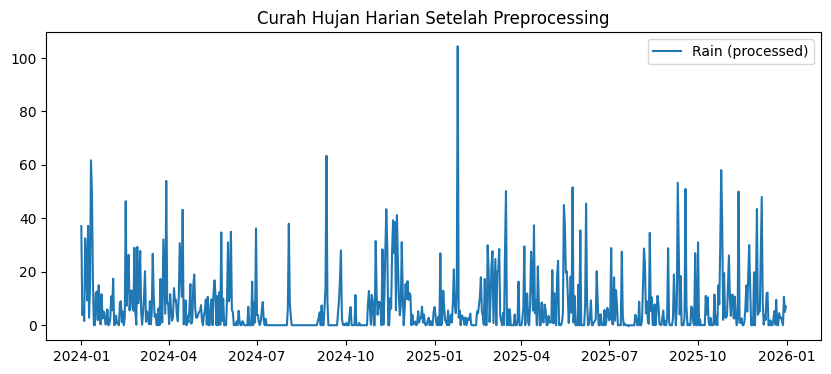

In [142]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Rain"], label="Rain (processed)")
plt.title("Curah Hujan Harian Setelah Preprocessing")
plt.legend()
plt.show()

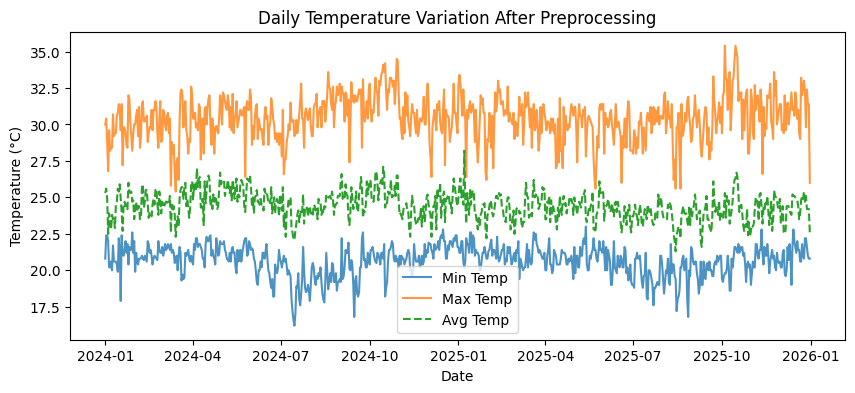

In [143]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Temp_Min"], label="Min Temp", alpha=0.8)
plt.plot(df.index, df["Temp_Max"], label="Max Temp", alpha=0.8)
plt.plot(df.index, df["Temp_Avg"], label="Avg Temp", linestyle="--")

plt.title("Daily Temperature Variation After Preprocessing")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

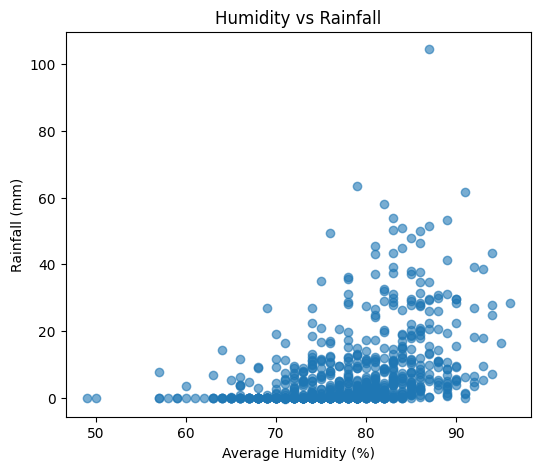

In [144]:
plt.figure(figsize=(6,5))
plt.scatter(df["Humidity"], df["Rain"], alpha=0.6)
plt.xlabel("Average Humidity (%)")
plt.ylabel("Rainfall (mm)")
plt.title("Humidity vs Rainfall")
plt.show()

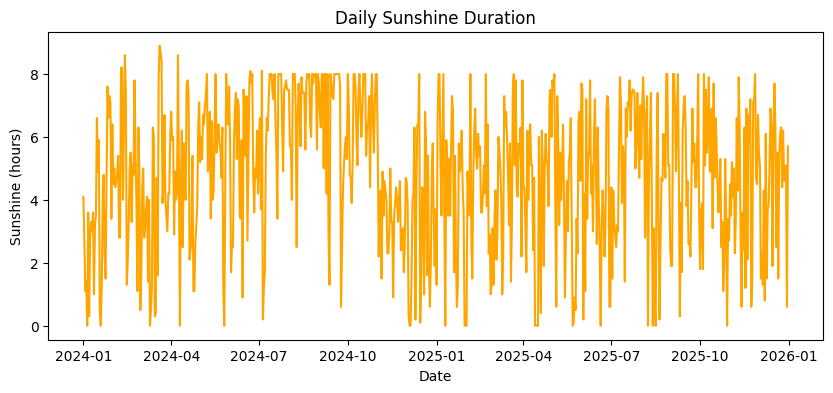

In [145]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Sunshine"], color="orange")
plt.title("Daily Sunshine Duration")
plt.xlabel("Date")
plt.ylabel("Sunshine (hours)")
plt.show()

In [164]:
def classify_weather_6(
    rr, rh, ss,
    tn, tx, tavg,
    ff_avg, ff_x
):
    """
    Rule-based daily weather classification (BMKG-inspired, 6 classes)

    Uses rainfall, humidity, sunshine, temperature, and wind variables
    to improve robustness while keeping categories simple.
    """

    # ---- SAFETY CHECK ----
    if any(v is None or pd.isna(v) for v in [rr, rh, ss, tn, tx, ff_avg, ff_x]):
        return "Cloudy"

    dtr = tx - tn  # diurnal temperature range

    # =====================================================
    # 1. RAIN-BASED CONDITIONS (DOMINANT)
    # =====================================================
    if rr >= 5:  # 🔧 FIX 1: effective rainfall
        if rr > 50 or (rr > 30 and ff_x >= 8):
            return "Heavy Rain"
        elif rr > 20:
            return "Moderate Rain"
        else:
            # 🔧 FIX 2: light rain but sunny hours still high
            if ss >= 5:
                return "Partly Cloudy"
            return "Light Rain"

    # =====================================================
    # 2. NO-RAIN CONDITIONS
    # =====================================================
    if ss >= 7 and rh < 75 and dtr >= 6:
        return "Sunny"

    if 4 <= ss < 7 and rh < 85:
        return "Partly Cloudy"

    return "Cloudy"


In [165]:
df["Weather_Class"] = df.apply(
    lambda r: classify_weather_6(
        rr=r["Rain"],
        rh=r["Humidity"],
        ss=r["Sunshine"],
        tn=r["Temp_Min"],
        tx=r["Temp_Max"],
        tavg=r["Temp_Avg"],
        ff_avg=r["Wind_Avg"],
        ff_x=r["Wind_Max"]
    ),
    axis=1
)

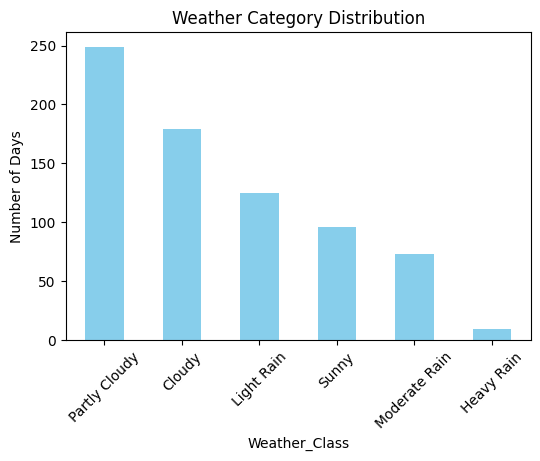

In [166]:
weather_counts = df["Weather_Class"].value_counts()

plt.figure(figsize=(6,4))
weather_counts.plot(kind="bar", color="skyblue")
plt.title("Weather Category Distribution")
plt.ylabel("Number of Days")
plt.xticks(rotation=45)
plt.show()

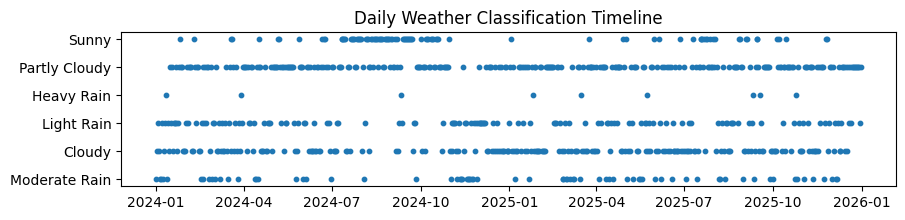

In [167]:
plt.figure(figsize=(10,2))
plt.scatter(df.index, df["Weather_Class"], s=10)
plt.title("Daily Weather Classification Timeline")
plt.yticks(rotation=0)
plt.show()

In [168]:
final_columns = [
    "Temp_Min", "Temp_Max", "Temp_Avg",
    "Humidity", "Rain", "Sunshine",
    "Wind_Max", "Wind_Avg",
    "Weather_Class"
]

df_final = df[final_columns].copy()
df_final.to_csv('/content/drive/MyDrive/ColabNotebooks/VisDatLanjut/Final Project/weather_bandung_2024_25.csv')
print(df_final.head())

            Temp_Min  Temp_Max  Temp_Avg  Humidity  Rain  Sunshine  Wind_Max  \
Date                                                                           
2024-01-01      20.8      30.0      25.3      81.0  37.1       4.1       3.0   
2024-01-02      22.4      30.4      25.6      82.0   3.8       2.7       1.0   
2024-01-03      22.4      28.8      24.9      83.0   6.4       1.1       3.0   
2024-01-04      22.0      26.8      22.5      91.0   1.6       1.4       2.0   
2024-01-05      20.2      29.6      23.9      82.0  32.5       0.0       5.0   

            Wind_Avg  Weather_Class  
Date                                 
2024-01-01       0.0  Moderate Rain  
2024-01-02       0.0         Cloudy  
2024-01-03       1.0     Light Rain  
2024-01-04       0.0         Cloudy  
2024-01-05       0.0  Moderate Rain  


In [169]:
df_final

,Temp_Min,Temp_Max,Temp_Avg,Humidity,Rain,Sunshine,Wind_Max,Wind_Avg,Weather_Class
Date,,,,,,,,,
2024-01-01,20.8,30.0,25.3,81.0,37.1,4.1,3.0,0.0,Moderate Rain
2024-01-02,22.4,30.4,25.6,82.0,3.8,2.7,1.0,0.0,Cloudy
2024-01-03,22.4,28.8,24.9,83.0,6.4,1.1,3.0,1.0,Light Rain
2024-01-04,22.0,26.8,22.5,91.0,1.6,1.4,2.0,0.0,Cloudy
2024-01-05,20.2,29.6,23.9,82.0,32.5,0.0,5.0,0.0,Moderate Rain
...,...,...,...,...,...,...,...,...,...
2025-12-27,22.2,29.8,25.1,71.0,1.5,4.6,3.0,1.0,Partly Cloudy
2025-12-28,21.6,32.4,24.2,78.0,0.0,4.7,5.0,0.0,Partly Cloudy
2025-12-29,21.0,31.4,24.2,79.0,10.6,5.1,2.0,0.0,Partly Cloudy
